# Libraries importing

In [1]:
from scipy.stats import randint

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Data loading and columns selection

In [2]:
selected_columns = ['age', 'stroke', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married', 'work_type',
                    'smoking_status', ]

df = pd.read_csv('data/processed_data.csv')
df = df[selected_columns]

df_naive = pd.read_csv('data/processed_data_copy.csv')
df.head()

,age,stroke,hypertension,heart_disease,avg_glucose_level,ever_married,work_type,smoking_status
0,6.0,1,0,1,0.594096,1,2,1
1,5.0,1,0,0,0.594096,1,3,2
2,7.0,1,0,1,0.583954,1,2,2
3,4.0,1,0,0,0.594096,1,2,3
4,7.0,1,1,0,0.594096,1,3,2


# Data splitting

In [3]:
x = df.drop('stroke', axis=1)
y = df['stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_naive = df_naive.drop('stroke', axis=1)
y_naive = df_naive['stroke']
x_train_naive, x_test_naive, y_train_naive, y_test_naive = train_test_split(x_naive, y_naive, test_size=0.2)

# Decision Tree Model

In [4]:
model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=30)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.96      0.82      0.89       971
           1       0.11      0.41      0.17        51

    accuracy                           0.80      1022
   macro avg       0.54      0.62      0.53      1022
weighted avg       0.92      0.80      0.85      1022



# Decision Tree Visualization

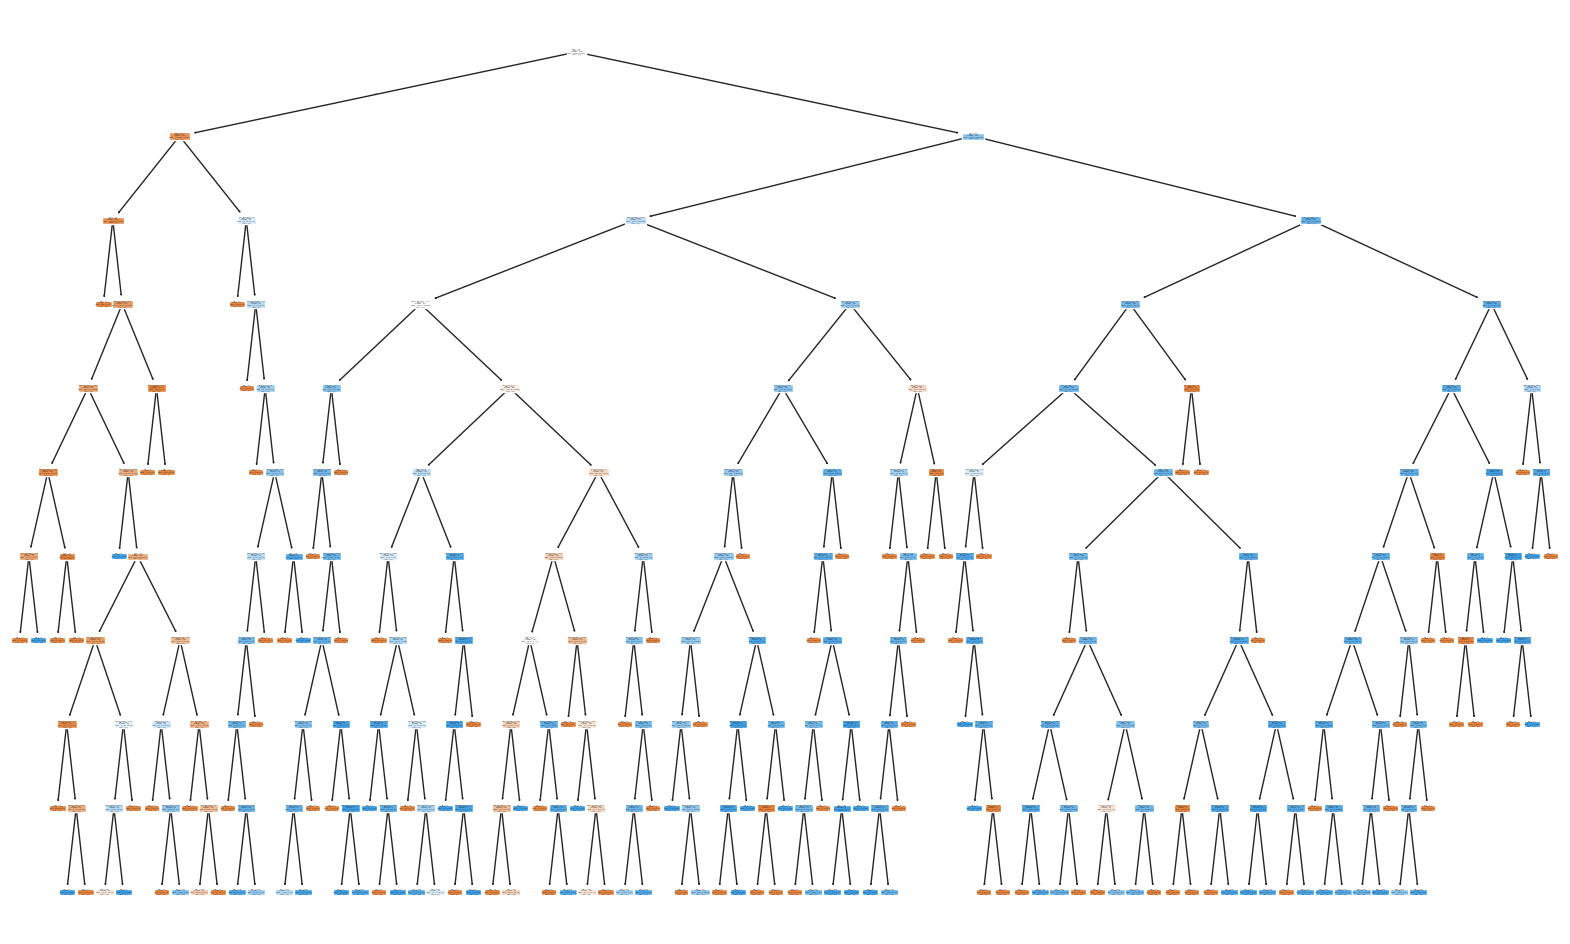

In [5]:
plt.figure(figsize=(20, 12))
plot_tree(model, filled=True, feature_names=selected_columns, class_names=True)
plt.savefig('tree.png')
plt.show()

# Random Forest Model

In [6]:
RF_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=30, min_samples_split=5,
                                  min_samples_leaf=1)
RF_model.fit(x_train, y_train)
RF_predictions = RF_model.predict(x_test)
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       971
           1       0.18      0.04      0.06        51

    accuracy                           0.94      1022
   macro avg       0.57      0.51      0.52      1022
weighted avg       0.91      0.94      0.93      1022



# Hyperparameter Tuning for Random Forest

In [7]:
# # Define a parameter grid for tuning
# param_grid = {
#     'n_estimators': [ 300,400,500,1000],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }
#
# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RF_model,
#     param_grid=param_grid,
#     cv=4,                 # 4-fold cross-validation
#     n_jobs=-1,            # use all CPU cores
#     verbose=2,
#     scoring='f1'
# )
#
# # Run grid search
# grid_search.fit(x_train, y_train)
#
# # Best parameters and model
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score:", grid_search.best_score_)
#
# # Evaluate on test set
# best_model = grid_search.best_estimator_
# test_score = best_model.score(x_test, y_test)
# print("Test Set Accuracy:", test_score)

# KNN Classifier

In [8]:
knclassifier = KNeighborsClassifier(n_neighbors=11, leaf_size=45, p=1, weights='uniform')
knclassifier.fit(x_train, y_train)
knn_predictions = knclassifier.predict(x_test)
print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       971
           1       0.33      0.04      0.07        51

    accuracy                           0.95      1022
   macro avg       0.64      0.52      0.52      1022
weighted avg       0.92      0.95      0.93      1022



In [9]:
param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': randint(10, 60)
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=knclassifier,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=30
)

random_search.fit(x_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

y_pred = random_search.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Params: {'leaf_size': 45, 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best Score: 0.9515539288888624
Test Accuracy: 0.9500978473581213


# Naive Bayes Classifier

In [10]:
nbclassifier = GaussianNB()
nbclassifier.fit(x_train_naive, y_train_naive)
nb_predictions = nbclassifier.predict(x_test_naive)
print(classification_report(y_test, nb_predictions))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92       971
           1       0.04      0.08      0.05        51

    accuracy                           0.85      1022
   macro avg       0.49      0.48      0.48      1022
weighted avg       0.90      0.85      0.87      1022



# Error Percentage (Misclassification Rate) for All Classifiers

In [35]:
dt_error = ((y_test != predictions).sum() / len(y_test)) * 100

rf_error = ((y_test != RF_predictions).sum() / len(y_test)) * 100

knn_error = ((y_test != knn_predictions).sum() / len(y_test)) * 100

nb_error = ((y_test_naive != nb_predictions).sum() / len(y_test_naive)) * 100

# Display results
print("=" * 50)
print("Error Percentage (Misclassification Rate) Summary")
print("=" * 50)
print(f"{'Classifier':<20} {'Error %':>10}")
print("-" * 50)
print(f"{'Decision Tree':<20} {dt_error:>10.2f}%")
print(f"{'Random Forest':<20} {rf_error:>10.2f}%")
print(f"{'KNN':<20} {knn_error:>10.2f}%")
print(f"{'Naive Bayes':<20} {nb_error:>10.2f}%")
print("=" * 50)

Error Percentage (Misclassification Rate) Summary
Classifier              Error %
--------------------------------------------------
Decision Tree             19.86%
Random Forest              5.68%
KNN                        5.19%
Naive Bayes               12.04%


## Visualization

In [25]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

## Decision Tree - Precision-Recall Curve

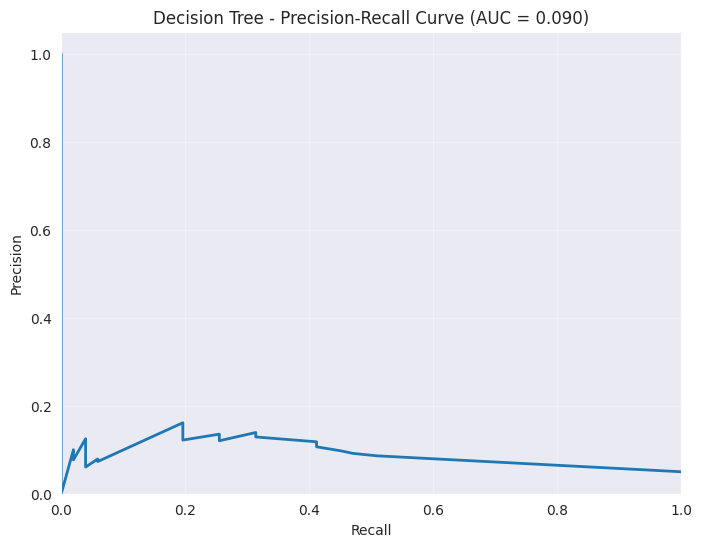

In [26]:
dt_probs = model.predict_proba(x_test)[:, 1]
precision_dt, recall_dt, _ = precision_recall_curve(y_test, dt_probs)
pr_auc_dt = auc(recall_dt, precision_dt)

plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, color='tab:blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Decision Tree - Precision-Recall Curve (AUC = {pr_auc_dt:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.3)
plt.show()

## Decision Tree - ROC Curve

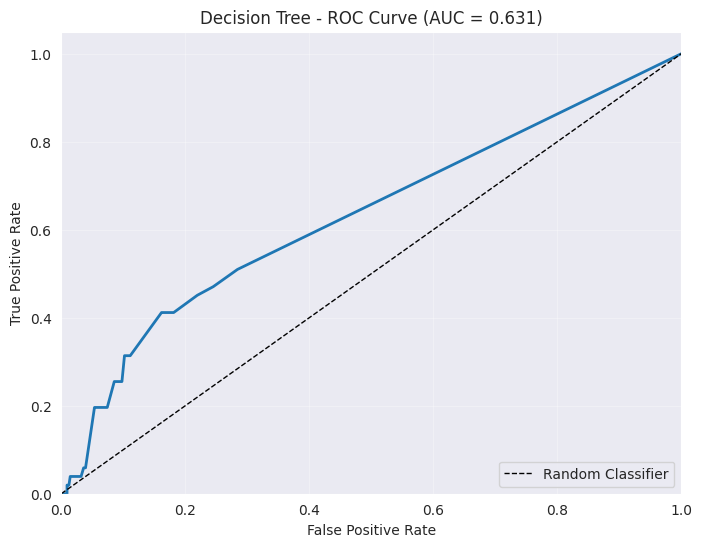

In [27]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='tab:blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Decision Tree - ROC Curve (AUC = {roc_auc_dt:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Random Forest - Precision-Recall Curve

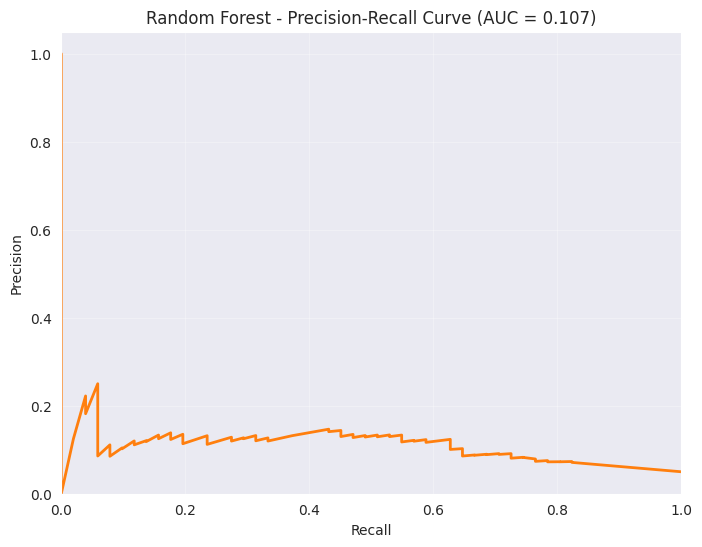

In [28]:
rf_probs = RF_model.predict_proba(x_test)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_probs)
pr_auc_rf = auc(recall_rf, precision_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='tab:orange', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Random Forest - Precision-Recall Curve (AUC = {pr_auc_rf:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.3)
plt.show()

## Random Forest - ROC Curve

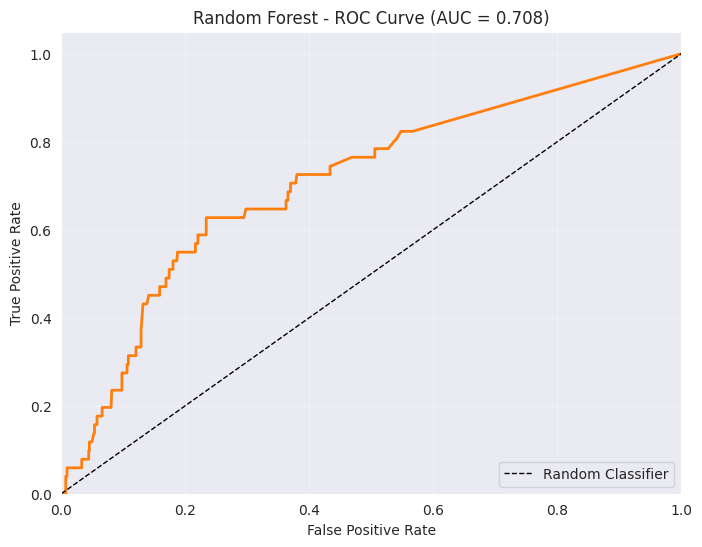

In [29]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='tab:orange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Random Forest - ROC Curve (AUC = {roc_auc_rf:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## KNN - Precision-Recall Curve

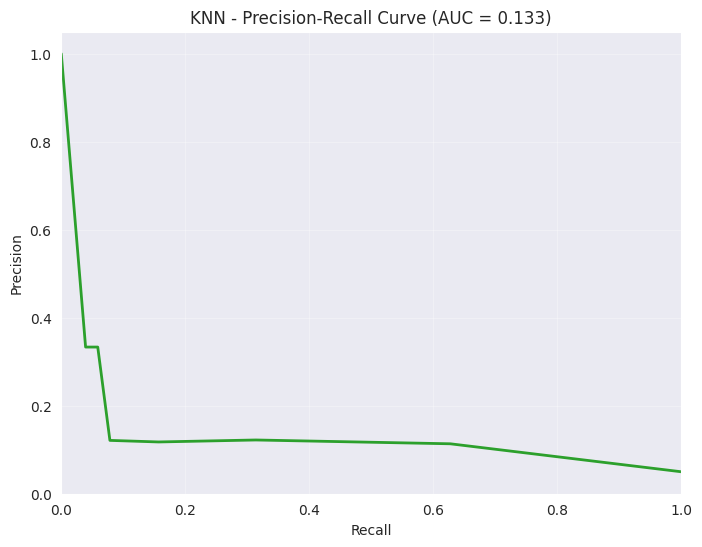

In [30]:
knn_probs = knclassifier.predict_proba(x_test)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_probs)
pr_auc_knn = auc(recall_knn, precision_knn)

plt.figure(figsize=(8, 6))
plt.plot(recall_knn, precision_knn, color='tab:green', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'KNN - Precision-Recall Curve (AUC = {pr_auc_knn:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.3)
plt.show()

## KNN - ROC Curve

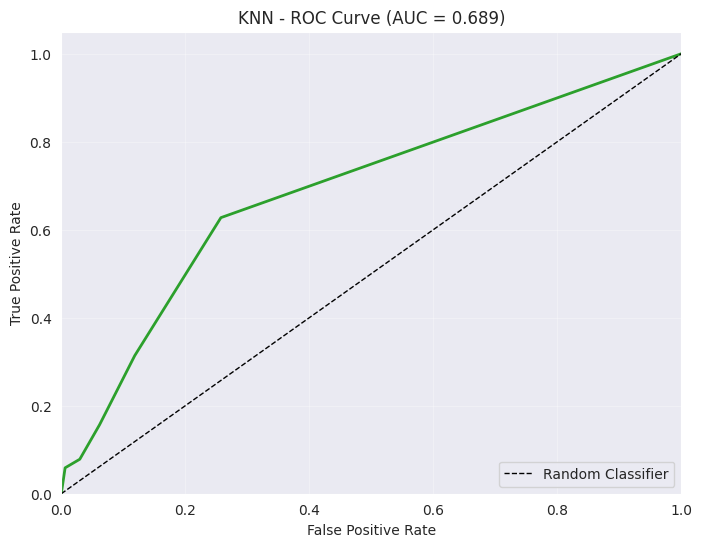

In [31]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='tab:green', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'KNN - ROC Curve (AUC = {roc_auc_knn:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Naive Bayes - Precision-Recall Curve

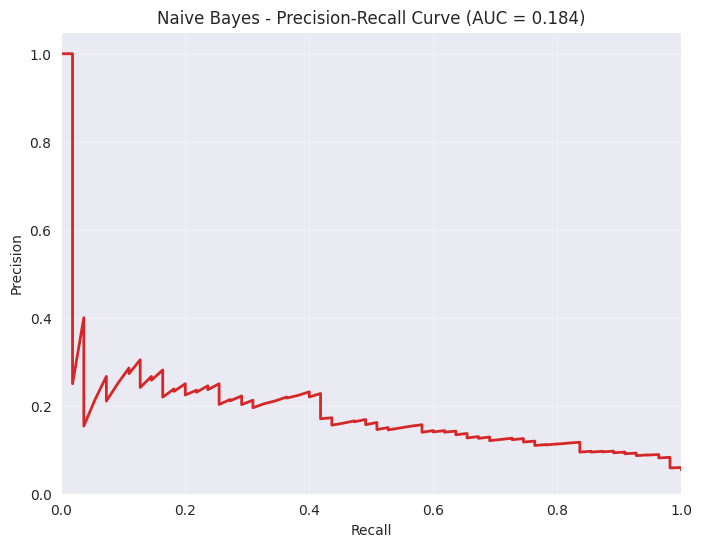

In [32]:
nb_probs = nbclassifier.predict_proba(x_test_naive)[:, 1]
precision_nb, recall_nb, _ = precision_recall_curve(y_test_naive, nb_probs)
pr_auc_nb = auc(recall_nb, precision_nb)

plt.figure(figsize=(8, 6))
plt.plot(recall_nb, precision_nb, color='tab:red', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Naive Bayes - Precision-Recall Curve (AUC = {pr_auc_nb:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.3)
plt.show()

## Naive Bayes - ROC Curve

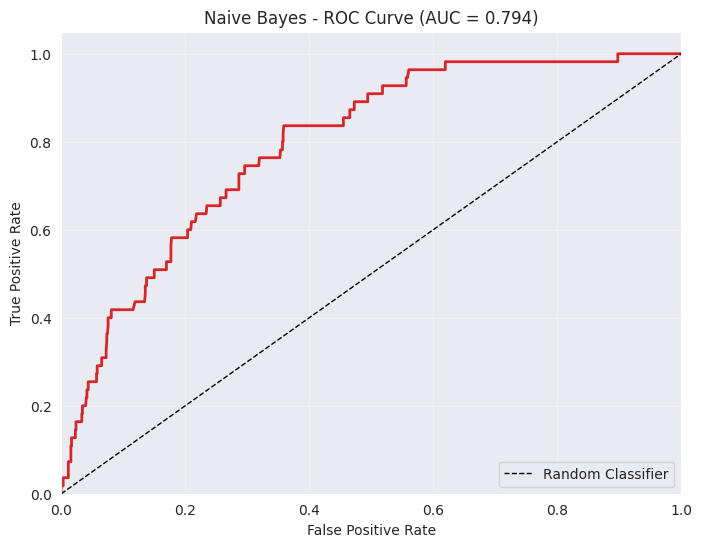

In [33]:
fpr_nb, tpr_nb, _ = roc_curve(y_test_naive, nb_probs)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='tab:red', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Naive Bayes - ROC Curve (AUC = {roc_auc_nb:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()
